# MetaNeighbor package in R formatting considerations:
MetaNeighbor

General data structure guidelines:

genes by cells matrix (r by c)
Row name = gene
Col name = cellid, must match cellid in pheno table below

Pheno table
Col1 = cellid, must match cellid in matrix above
col2 = studyid
Col3 = celltype, must match cell type in cell types list below

Celltypes list
List of all possible celltypes, must match cell types above

Specific guidelines for our data: 

genes by cells matrix (r by c)
Row name = gene
Col name = cellid, must match cellid in pheno table below

Pheno table (data.frame)
Col1 = cellid, must match cellid in matrix above AKA cell barcode
col2 = studyid AKA Parental, LVM1, or LVM2
Col3 = celltype, must match cell type in cell types list below,  AKA cluster numbers from SC3, with heading denoting parental population appended to front

Celltypes list
List of all possible celltypes, must match cell types above

###These have to be in a SEO object from package SummarizedExperiment in R:

####ex: 
> mn_data
class: SummarizedExperiment 
dim: 3157 1051 
metadata(0):
assays(1): gene_matrix
rownames(3157): 1110017D15Rik 1190002N15Rik ... Zw10 Zwint
rowData names(0):
colnames(1051): 1772071015_C02 1772071017_G12 ...
  Vip_tdTpositive_cell_67 Vip_tdTpositive_cell_68
colData names(3): sample_id study_id cell_type


# ##note that MetaNeighbor is for R >3.5.0, so exported data for use in R-dev

In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

# Initial cluster matching

In [2]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(SummarizedExperiment)
###readin
P <- readRDS("scater/separately_clustered/sc3_clustered_P.rds")
LVM1 <- readRDS("scater/separately_clustered/sc3_clustered_LVM1.rds")
LVM2 <- readRDS("scater/separately_clustered/sc3_clustered_LVM2.rds")

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching pack

In [3]:
%%R

###############format genes by cells matrix
P_data <- logcounts(P)
LVM1_data <- logcounts(LVM1)
LVM2_data <- logcounts(LVM2)
#####concatenate
All_data <- cbind(P_data,LVM1_data,LVM2_data)
dim(All_data)

[1] 13311  7418


In [4]:
%%R

###############format pheno table

########Parental first ; code is factored
#####define columns
Sample_ID = colnames(P)
Study_ID = c(rep("P",length(Sample_ID)))
Celltype = colData(P)$sc3_2_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
P_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))
#########LVM1
#####define columns
Sample_ID = colnames(LVM1)
Study_ID = c(rep("LVM1",length(Sample_ID)))
Celltype = colData(LVM1)$sc3_4_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
LVM1_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))
#########LVM2
#####define columns
Sample_ID = colnames(LVM2)
Study_ID = c(rep("LVM2",length(Sample_ID)))
Celltype = colData(LVM2)$sc3_5_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
LVM2_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))

#######concatenate
All_pheno <- data.frame(rbind(P_pheno,LVM1_pheno,LVM2_pheno))
dim(All_pheno)

[1] 7418    3


In [5]:
%%R

########get Celltypes list
All_celltypes <- levels(as.factor(All_pheno$Celltype))

In [6]:
%%R

#############create SummarizedExperiment object
final_SEO <- SummarizedExperiment(assays=list(gene_matrix=All_data),colData=All_pheno)
#############create SingleCellExperiment object
scdata_clustd <- SingleCellExperiment(assays = list(logcounts = All_data),colData=All_pheno)

In [7]:
%%R

########save
save(final_SEO, file = "metaneighbor/041518_MN_ready.RData")
########save
save(scdata_clustd, file="metaneighbor/041518_post_clust.RData")

### Cluster matching showed concurrence between LVM1 and LVM2 clusters; however parental clusters did not match well with LVM1 or LVM2 clusters. This makes sense given that in the initial round of metastatic selection there is likely a selection of a few low abundance cells.

We can try to match the LVM1 clusters to specific cells in the parental population, by assigning each "cell" as a unique identity

### Additionally, LVM2 showed one cluster (LVM2_1) that was not similar to anything from LVM1 ; this cluster could be interesting, and could represent a new metastatic derivative.

# Metaneighbor round 2 with more clusters from parental (23)
####note that clusters from Parental with k = 23 are over clustered, but the goal here is to find clusters that match to LVM1

In [30]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(SummarizedExperiment)
###readin
P <- readRDS("scater/separately_clustered/sc3_clustered_P.rds")
LVM1 <- readRDS("scater/separately_clustered/sc3_clustered_LVM1.rds")
LVM2 <- readRDS("scater/separately_clustered/sc3_clustered_LVM2.rds")

In [31]:
%%R

###############format genes by cells matrix
P_data <- logcounts(P)
LVM1_data <- logcounts(LVM1)
LVM2_data <- logcounts(LVM2)
#####concatenate
All_data <- cbind(P_data,LVM1_data,LVM2_data)
dim(All_data)

[1] 13311  7418


In [32]:
%%R

###############format pheno table

########Parental first ; code is factored
#####define columns
Sample_ID = colnames(P)
Study_ID = c(rep("P",length(Sample_ID)))
Celltype = colData(P)$sc3_23_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
P_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))
#########LVM1
#####define columns
Sample_ID = colnames(LVM1)
Study_ID = c(rep("LVM1",length(Sample_ID)))
Celltype = colData(LVM1)$sc3_4_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
LVM1_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))
#########LVM2
#####define columns
Sample_ID = colnames(LVM2)
Study_ID = c(rep("LVM2",length(Sample_ID)))
Celltype = colData(LVM2)$sc3_5_clusters
Celltype = paste(Study_ID, Celltype, sep = '_')
####combine
LVM2_pheno <- data.frame(cbind(Sample_ID,Study_ID,Celltype))

#######concatenate
All_pheno <- data.frame(rbind(P_pheno,LVM1_pheno,LVM2_pheno))
dim(All_pheno)

[1] 7418    3


In [33]:
%%R

########get Celltypes list
All_celltypes <- levels(as.factor(All_pheno$Celltype))

In [34]:
%%R

#############create SummarizedExperiment object
final_SEO <- SummarizedExperiment(assays=list(gene_matrix=All_data),colData=All_pheno)
#############create SingleCellExperiment object
scdata_clustd <- SingleCellExperiment(assays = list(logcounts = All_data),colData=All_pheno)

In [35]:
%%R

########save
save(final_SEO, file = "metaneighbor/041618_MN_ready_round2.RData")
########save
save(scdata_clustd, file="metaneighbor/041618_post_clust_round2.RData")

# Visualize post-clustering

In [14]:
%%R
##
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(SummarizedExperiment)
############load data
load(file="metaneighbor/041518_post_clust.RData")
####
scdata <- scdata_clustd
####run TSNE
perplex=50
scdata <- runTSNE(scdata,exprs_values='logcounts',perplexity = perplex,rand_seed = 50000)

# Analysis of LVM1 -> LVM2

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


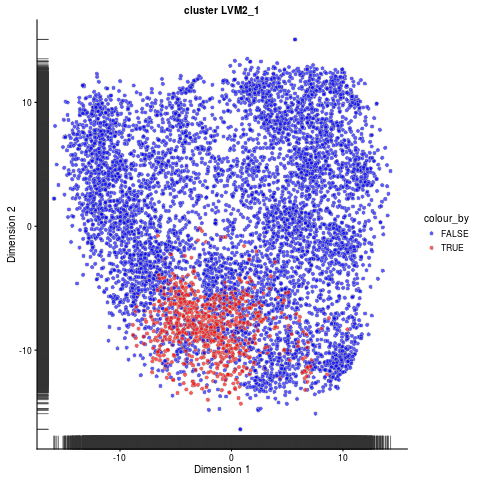

In [15]:
%%R
####define visualization cluster
vis_cluster <- "LVM2_1"
####read into object
tmp <- colData(scdata)$Celltype
tmp <- (tmp == vis_cluster)
colData(scdata)$vis_clust <- tmp
####plot
plotTSNE(
    scdata,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

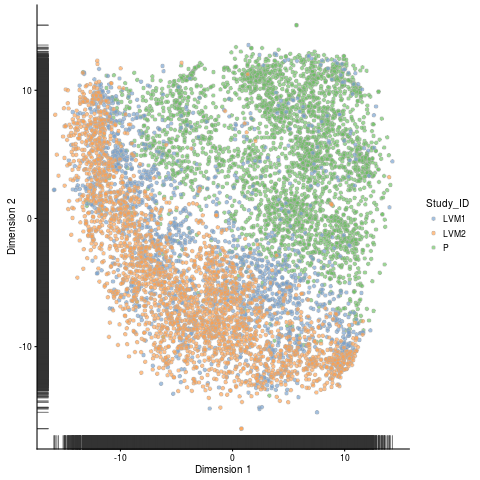

In [17]:
%%R


###plot TSNE
plotTSNE(
    scdata,
    colour_by = "Study_ID"
)


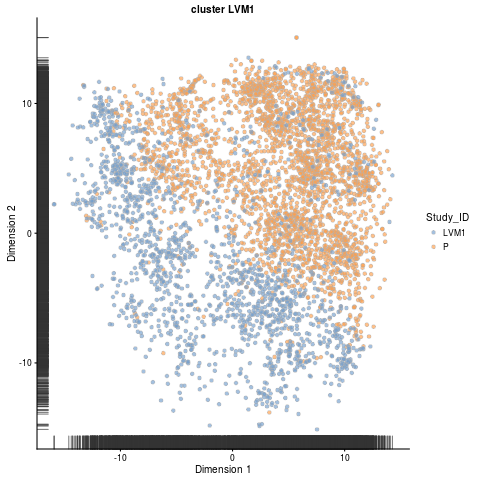

In [27]:
%%R
###subset
exclude <- "LVM2"
###
tmp <- scdata[ , colData(scdata)$Study_ID != exclude]
####plot
plotTSNE(
    tmp,
    colour_by = "Study_ID",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" "))

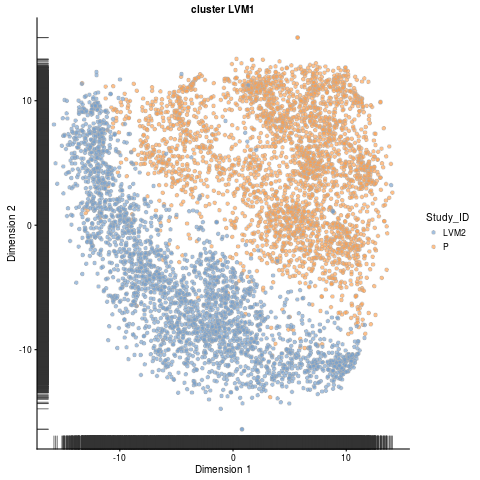

In [28]:
%%R
###subset
exclude <- "LVM1"
###
tmp <- scdata[ , colData(scdata)$Study_ID != exclude]
####plot
plotTSNE(
    tmp,
    colour_by = "Study_ID",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" "))

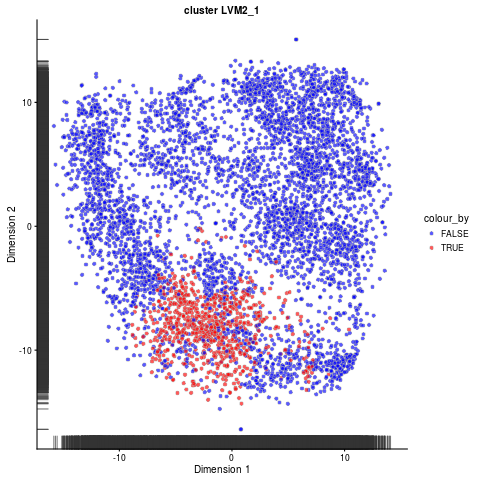

In [29]:
%%R
####define visualization cluster
vis_cluster <- "LVM2_1"
###subset
exclude <- "LVM1"
###
tmp <- scdata[ , colData(scdata)$Study_ID != exclude]
####read into object
tmp_col <- colData(tmp)$Celltype
tmp_col <- (tmp_col == vis_cluster)
colData(tmp)$vis_clust <- tmp_col
####plot
plotTSNE(
    tmp,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

# Conclusion: 
## Metastatic cluster "LVM2_1" seems like a new outgrowth of a metastatic derivative, and doesn't present in high abundance in LVM1
## therefore this could be a new outgrowth with novel metastatic capability
## additionally, this cluster progresses away from P and LVM1, on the same "metastatic axis"

###question: how much of the variance in the LVM2 dataset comes from this cluster of cells? Is this driving the increased metastatic signature?

# Sanity Check
## metaneighbor says LVM1_3 matches LVM2_4
## metaneighbor says LVM1_2 matches LVM2_3

## visualize these to see if that makes sense

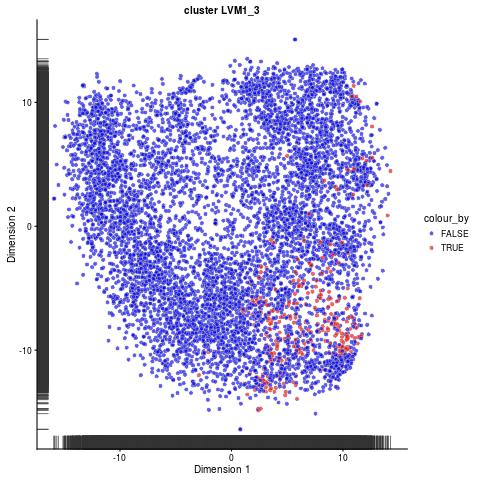

In [36]:
%%R
####define visualization cluster
vis_cluster <- "LVM1_3"
####read into object
tmp <- colData(scdata)$Celltype
tmp <- (tmp == vis_cluster)
colData(scdata)$vis_clust <- tmp
####plot
plotTSNE(
    scdata,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

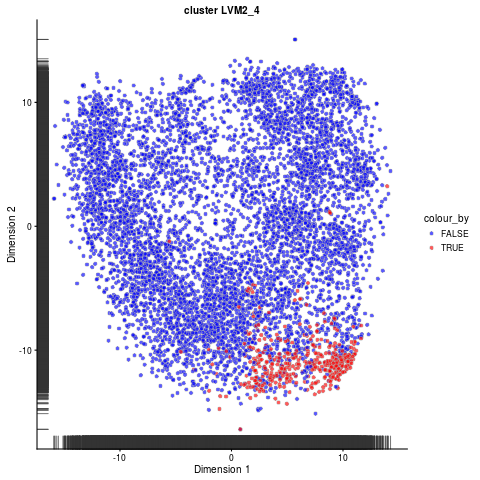

In [37]:
%%R
####define visualization cluster
vis_cluster <- "LVM2_4"
####read into object
tmp <- colData(scdata)$Celltype
tmp <- (tmp == vis_cluster)
colData(scdata)$vis_clust <- tmp
####plot
plotTSNE(
    scdata,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

## LVM1_3 and LVM2_4 match

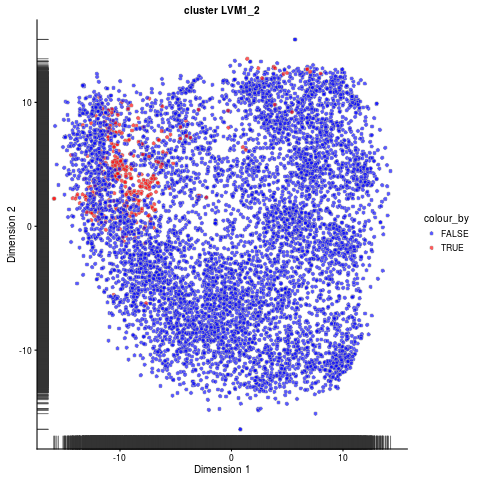

In [38]:
%%R
####define visualization cluster
vis_cluster <- "LVM1_2"
####read into object
tmp <- colData(scdata)$Celltype
tmp <- (tmp == vis_cluster)
colData(scdata)$vis_clust <- tmp
####plot
plotTSNE(
    scdata,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

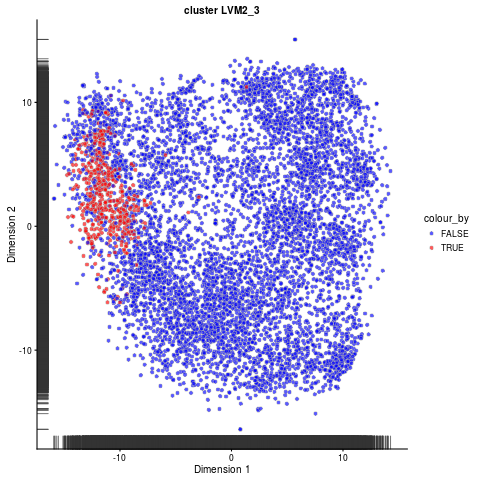

In [39]:
%%R
####define visualization cluster
vis_cluster <- "LVM2_3"
####read into object
tmp <- colData(scdata)$Celltype
tmp <- (tmp == vis_cluster)
colData(scdata)$vis_clust <- tmp
####plot
plotTSNE(
    scdata,
    colour_by = "vis_clust",
) + ggtitle(paste("cluster",toString(vis_cluster),sep=" ")) + scale_fill_manual(values=c("FALSE"="blue", "TRUE"="red"))

## LVM1_2 and LVM2_3 match